# Data-driven prediction model on Diabetes Patient's Hospital Readmission

In the realm of contemporary healthcare, the management and treatment of diabetes remain a formidable challenge. Diabetes is not only a prevalent chronic disease affecting billions globally but also its complications often necessitate complex and ongoing medical interventions. In this context, hospital readmission of diabetes patients has emerged as a significant issue, imposing substantial economic and psychological burdens on patients, as well as straining healthcare system resources.

Addressing this issue, this study aims to develop a data-driven predictive model to estimate the risk and timing of hospital readmission for diabetes patients. The development of this model is predicated on an in-depth analysis of historical medical records, encompassing but not limited to patient demographics, medical history, treatment records, and biochemical markers. Employing advanced data preprocessing techniques and machine learning algorithms, such as Random Forests, Support Vector Machines, and Neural Networks, this research seeks to provide an accurate and reliable predictive tool. This tool is intended not only to aid healthcare providers in making more informed decisions regarding resource allocation and patient management but also to offer more personalized and timely medical interventions for diabetes patients.

By reducing unnecessary readmissions, this model is anticipated to significantly enhance the quality of life for diabetes patients and alleviate their economic burdens. Concurrently, it offers the healthcare system an effective tool to better cope with the growing patient demand and the limitations of healthcare resources

Our goal is to:
1. Preprocess the diabetes patient's data, take out useless information.
2. Find factors which are the strongest predictors of hospital readmission in diabetic patients
3. Compare different method to find the best fit model for prediction
4. Try our best to predict hospital readmission in this dataset with limited features


In [138]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from IPython.display import display

# DataSet Description


In [139]:
file_path = "./features/FeatureTable.xlsx"
columns_to_read = ["Variable Name","Description"]

pd.set_option('display.max_columns', None) 
pd.set_option('display.expand_frame_repr', False)  
pd.set_option('display.max_colwidth', None)  

feature_table = pd.read_excel(file_path, usecols=columns_to_read)
feature_table

,Variable Name,Description
0,encounter_id,Unique identifier of an encounter
1,patient_nbr,Unique identifier of a patient
2,race,"Values: Caucasian, Asian, African American, Hispanic, and other"
3,gender,"Values: male, female, and unknown/invalid"
4,age,"Grouped in 10-year intervals: [0, 10), [10, 20),..., [90, 100)"
5,weight,Weight in pounds.
6,admission_type_id,"Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available"
7,discharge_disposition_id,"Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available"
8,admission_source_id,"Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital"
9,time_in_hospital,Integer number of days between admission and discharge


# Raw Data Exploration

In [140]:
class DataExploration(object):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)

        # Assuming 'data' is the dataset 
        self.df = pd.DataFrame(self.data)

    def pie_race_distribution(self):
        # Plot the pie chart for Race Distribution

        # Calculate the counts for different races
        Caucasian_count = len(self.data[self.data['race'] == 'Caucasian'])
        Asian_count = len(self.data[self.data['race'] == 'Asian'])
        African_count = len(self.data[self.data['race'] == 'African'])
        American_count = len(self.data[self.data['race'] == 'American'])
        Hispanic_count = len(self.data[self.data['race'] == 'Hispanic'])
        other_count = len(self.data[self.data['race'] == 'Other'])

        total_count = len(self.data)

        # Calculate percentages
        p1 = (Caucasian_count / total_count) * 100
        p2 = (Asian_count / total_count) * 100
        p3 = (African_count / total_count) * 100
        p6 = (American_count / total_count) * 100
        p5 = (Hispanic_count / total_count) * 100
        p4 = (other_count / total_count) * 100

        print(f"Percentage Caucasian: {p1}%")
        print(f"Percentage Asian: {p2}%")
        print(f"Percentage African: {p3}%")
        print(f"Percentage American: {p6}%")
        print(f"Percentage Hispanic: {p5}%")
        print(f"Percentage Other: {p4}%")

        labels = ['Caucasian', 'Asian', 'African', 'other', 'Hispanic', 'America']
        sizes = [p1, p2, p3, p4, p5, p6]  # Portions for the pie chart

        # Set the colors
        colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'orange', 'pink']

        # Plot the figure
        plt.figure(figsize=(20, 20))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

        # Set the title
        plt.title('Race distribution')

        # Show the plot
        plt.axis('equal')  # Ensure it's a circle and not an ellipse
        plt.legend() 
        plt.show()

    def pie_a1cresult(self):
        # Plot the pie chart for A1Cresult Value

        # Calculate the counts for different A1Cresult categories
        normal_count = len(self.data[self.data['A1Cresult'] == 'Normal'])
        gt_8_count = len(self.data[self.data['A1Cresult'] == '>8'])
        gt_7_count = len(self.data[self.data['A1Cresult'] == '>7'])
        none_count = len(self.data[self.data['A1Cresult'] == 'None'])

        total_count = len(self.data)

        # Calculate percentages
        p1 = (normal_count / total_count) * 100
        p2 = (gt_8_count / total_count) * 100
        p3 = (gt_7_count / total_count) * 100
        p4 = (none_count / total_count) * 100

        print(f"Percentage Normal: {p1:.2f}%")
        print(f"Percentage >8: {p2:.2f}%")
        print(f"Percentage >7: {p3:.2f}%")
        print(f"Percentage None: {p4:.2f}%")

        labels = ['Normal', '>8','None', '>7']
        sizes = [p1, p2, p4, p3]  # Portions for the pie chart

        # Set the colors
        colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

        # Plot the figure
        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

        # Set the title
        plt.title('A1Cresult Value')

        # Show the plot
        plt.axis('equal')  # Ensure it's a circle and not an ellipse
        plt.legend(loc='upper right') 
        plt.show()

    def stacked_medicine_use_condition(self):
        # PLot the Stacked Column Chart for Medicine use condition

        # Define all the medicines
        medicines = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']  # 添加其他药物的名称

        # create a vaccume list to fill the percentage
        percentages = []

        # write a loop to deal all of the medicines
        for med in medicines:
            # write the percentage for each medicines
            values_count = self.data[med].value_counts(normalize=True) * 100
            
            # for none value use o to replace
            for value in ['No', 'Steady', 'Up', 'Down']:
                if value not in values_count:
                    values_count[value] = 0
            
            # put the percentage into the value list
            percentages.append([values_count['No'], values_count['Steady'], values_count['Up'], values_count['Down']])

        # define medicine name
        medication_labels = [med.capitalize() for med in medicines]  # Using the first character

        # define the colour 
        colors = ["steelblue","dodgerblue", "lightskyblue", "blue"]

        # create figure
        fig, ax = plt.subplots(figsize=(12, 8))
        fig.patch.set_facecolor('white') 

        bottom = np.zeros(len(medicines))  # initialise the bottom height

        for j in range(len(percentages[0])):
            values = [percentages[i][j] for i in range(len(medicines))]
            ax.bar(medicines, values, color=colors[j], bottom=bottom, label=["No", "Steady", "Up", "Down"][j])
            bottom += np.array(values)  # update the height

        # set the title 
        ax.set_title("Relationship between readmission and medicines", fontsize=15)
        ax.set_xlabel("Name of medicines")
        ax.set_ylabel("Percentage")
        ax.legend()  

        plt.xticks(medicines, medication_labels)  # x axis is the medicine name
        plt.xticks(rotation=45)  # rotate name avoid overlap
        ax.set_ylim(0, 105) 
        plt.tight_layout()  
        plt.show()

    def histogram_age_groups(self):
        # PLot the Histogram and find the skewness of the Age groups.

        # Create a numeric mapping for age categories for all patients
        age_mapping = {age: idx for idx, age in enumerate(sorted(self.data['age'].unique()))}
        self.data['age_numeric'] = self.data['age'].map(age_mapping)

        # Calculate skewness for the age category
        age_skewness = skew(self.data['age_numeric'])

        # Plot the histogram with KDE and display the skewness on the plot
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(data=self.data, x='age_numeric', bins=len(age_mapping), kde=True, kde_kws={"bw_adjust": 3.5})
        plt.title("Age Distribution with KDE for All Patients")
        plt.xlabel("Age Category")
        plt.ylabel("Density")
        plt.xticks(ticks=range(len(age_mapping)), labels=sorted(self.data['age'].unique()), rotation=45)
        plt.grid(True)

        # Create a second y-axis to show the count
        ax2 = ax.twinx()
        sns.histplot(data=self.data, x='age_numeric', bins=len(age_mapping), ax=ax2, alpha=0.5)
        ax2.set_ylabel('Count')

        # Annotate skewness on the plot
        ax.text(x=0.95, y=0.95, s=f"Skewness: {age_skewness:.2f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

    def histogram_time_in_hospital(self):
        # PLot the Histogram and find the skewness of time in hospital.

        # Calculate skewness for the time in hospital
        time_in_hospital_skewness = skew(self.df['time_in_hospital'])

        # Plot the histogram with KDE and display the skewness on the plot
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(data=self.df, x='time_in_hospital', bins=max(self.df['time_in_hospital']), kde=True, kde_kws={"bw_adjust": 3.5})
        plt.title("Time in Hospital Distribution with KDE")
        plt.xlabel("Time in Hospital (days)")
        plt.ylabel("Density")
        plt.xticks(ticks=range(1, max(self.df['time_in_hospital']) + 1))
        plt.grid(True)

        # Create a second y-axis to show the count
        ax2 = ax.twinx()
        sns.histplot(data=self.df, x='time_in_hospital', bins=max(self.df['time_in_hospital']), ax=ax2, alpha=0.5)
        ax2.set_ylabel('Count')

        # Annotate skewness on the plot
        ax.text(x=0.95, y=0.95, s=f"Skewness: {time_in_hospital_skewness:.2f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

        plt.show()

    def chart_change_in_medications(self):
        # Plot the # PLot the Stacked Column Chart for The change in medications

        # Set the limitations to find the desirable line
        d1 = len(self.df[(self.df['change'] == 'No') & (self.df['readmitted'] == 'NO')])
        d2 = len(self.df[(self.df['change'] == 'No') & (self.df['readmitted'] == '<30')])
        d3 = len(self.df[(self.df['change'] == 'No') & (self.df['readmitted'] == '>30')])
        d4 = len(self.df[(self.df['change'] == 'Ch') & (self.df['readmitted'] == 'NO')])
        d5 = len(self.df[(self.df['change'] == 'Ch') & (self.df['readmitted'] == '<30')])
        d6 = len(self.df[(self.df['change'] == 'Ch') & (self.df['readmitted'] == '>30')])

        # Define the total line
        total_line = len(self.df)

        # Calculate the percentage of the desirable line over the total line
        p1 = (d1 / total_line) * 100
        p2 = (d2 / total_line) * 100
        p3 = (d3 / total_line) * 100
        p4 = (d4 / total_line) * 100
        p5 = (d5 / total_line) * 100
        p6 = (d6 / total_line) * 100

        # Print the actual percentage
        print(total_line)
        print(f"change 'No' and readmitted 'NO': {p1}%")
        print(f"change 'No' and readmitted '<30': {p2}%")
        print(f"change 'No' and readmitted '>30': {p3}%")
        print(f"change 'Ch' and readmitted 'NO': {p4}%")
        print(f"change 'Ch' and readmitted '<30': {p5}%")
        print(f"change 'Ch' and readmitted '>30': {p6}%")

        #define the two bars
        readmission = ["change", "NO change"]
        NO = [p1, p4]  # You might want to replace p1, p4 with actual numerical values
        less_than_30_days = [p2, p5]  # Fix variable names with underscores
        more_than_30_days = [p3, p6]  # Fix variable names with underscores

        #define the size of the bar
        fig, ax = plt.subplots(figsize=(10, 7))
        #define the backfround colour
        fig.patch.set_facecolor('white') 
        #ax.grid(color='white') 

        # Plotting the bars with different colours
        ax.bar(readmission, NO, color="darkolivegreen", label="NO")
        ax.bar(readmission, less_than_30_days, color="darkgreen", bottom=NO, label="Less than 30 days")
        ax.bar(readmission, more_than_30_days, color="darkseagreen", bottom=np.array(less_than_30_days) + np.array(NO), label="More than 30 days")

        # Set plot labels and title
        ax.set_title("Relationship between readission and Change in diebatic medications", fontsize=15)
        ax.set_xlabel("Change condition")
        ax.set_ylabel("Percentage")
        ax.legend()  # If 'A' is supposed to be the legend label, use ax.legend(["A"])

        plt.show()  # Display the plot

    def chart_diabetesMed(self):
        # Plot the # PLot the Stacked Column Chart for The diabetesMed

        # Set the limitations to find the desirable line
        d1 = len(self.df[(self.df['diabetesMed'] == 'No') & (self.df['readmitted'] == 'NO')])
        d2 = len(self.df[(self.df['diabetesMed'] == 'No') & (self.df['readmitted'] == '<30')])
        d3 = len(self.df[(self.df['diabetesMed'] == 'No') & (self.df['readmitted'] == '>30')])
        d4 = len(self.df[(self.df['diabetesMed'] == 'Yes') & (self.df['readmitted'] == 'NO')])
        d5 = len(self.df[(self.df['diabetesMed'] == 'Yes') & (self.df['readmitted'] == '<30')])
        d6 = len(self.df[(self.df['diabetesMed'] == 'Yes') & (self.df['readmitted'] == '>30')])


        # Define the total line
        total_line = len(self.df)

        # Calculate the percentage of the desirable line over the total line
        p1 = (d1 / total_line) * 100
        p2 = (d2 / total_line) * 100
        p3 = (d3 / total_line) * 100
        p4 = (d4 / total_line) * 100
        p5 = (d5 / total_line) * 100
        p6 = (d6 / total_line) * 100


        # Print the actual percentage
        print(total_line)
        print(f"diabetesMed 'No' and readmitted 'NO': {p1}%")
        print(f"diabetesMed 'No' and readmitted '<30': {p2}%")
        print(f"diabetesMed 'No' and readmitted '>30': {p3}%")
        print(f"diabetesMed 'Yes' and readmitted 'NO': {p4}%")
        print(f"diabetesMed 'Yes' and readmitted '<30': {p5}%")
        print(f"diabetesMed 'Yes' and readmitted '>30': {p6}%")


        # import the figure plotting code
        import matplotlib.pyplot as plt
        import numpy as np

        #define the two bars
        readmission = ["Yes", "NO"]
        NO = [p4, p1]  # You might want to replace p1, p4 with actual numerical values
        less_than_30_days = [p5, p2]  # Fix variable names with underscores
        more_than_30_days = [p6, p3]  # Fix variable names with underscores

        #define the size of the bar
        fig, ax = plt.subplots(figsize=(10, 7))
        #define the backfround colour
        fig.patch.set_facecolor('white') 
        #ax.grid(color='white') 

        # Plotting the bars with different colours
        ax.bar(readmission, NO, color="darkolivegreen", label="NO")
        ax.bar(readmission, less_than_30_days, color="darkgreen", bottom=NO, label="Less than 30 days")
        ax.bar(readmission, more_than_30_days, color="darkseagreen", bottom=np.array(less_than_30_days) + np.array(NO), label="More than 30 days")

        # Set plot labels and title
        ax.set_title("Relationship between readission and DiabeteMed", fontsize=15)
        ax.set_xlabel("DiabeteMed prescribed")
        ax.set_ylabel("Percentage")
        ax.legend()  # If 'A' is supposed to be the legend label, use ax.legend(["A"])

        plt.show()  # Display the plot

    def distribution_time_in_hospital(self):
        # Plot the distribution for Time in Hospital

        # Check the unique values in the 'readmitted' column to understand what categories we have
        readmitted_categories = self.df['readmitted'].unique()

        # Set up the matplotlib figure
        plt.figure(figsize=(12, 6))


        # Loop through each race and plot the distribution of 'time_in_hospital'
        for readmitted in readmitted_categories:
            # Exclude rows where readitted is not specified ('?')
            if readmitted != '?':
                subset = self.df[self.df['readmitted'] == readmitted]['time_in_hospital']
                sns.kdeplot(subset, fill=True, label=readmitted, bw_adjust=2)

        # Add plot title and labels
        plt.title('Distribution of Hospital Stay Duration by readmitted status')
        plt.xlabel('Time in Hospital (Days)')
        plt.ylabel('Density')

        # Display the legend
        plt.legend(title='Readmitted status')

        # Show the plot
        plt.show()

    def distribution_number_medications(self):
        # Plot the distribution for Number of medications
        readmitted_categories = self.df['readmitted'].unique()

        # Set up the matplotlib figure
        plt.figure(figsize=(12, 6))


        # Loop through each race and plot the distribution of 'time_in_hospital'
        for readmitted in readmitted_categories:
            # Exclude rows where readitted is not specified ('?')
            if readmitted != '?':
                subset = self.df[self.df['readmitted'] == readmitted]['num_medications']
                sns.kdeplot(subset, fill=True, label=readmitted, bw_adjust=2)

        # Add plot title and labels
        plt.title('Distribution of Number of Medications Duration by readmitted status')
        plt.xlabel('Number of Medications')
        plt.ylabel('Density')

        # Display the legend
        plt.legend(title='Readmitted status')

        # Show the plot
        plt.show()

    def distribution_number_procedures(self):
        # Plot the distribution for Number of Procedures
        readmitted_categories = self.df['readmitted'].unique()

        # Set up the matplotlib figure
        plt.figure(figsize=(12, 6))


        # Loop through each race and plot the distribution of 'time_in_hospital'
        for readmitted in readmitted_categories:
            # Exclude rows where readitted is not specified ('?')
            if readmitted != '?':
                subset = self.df[self.df['readmitted'] == readmitted]['num_procedures']
                sns.kdeplot(subset, fill=True, label=readmitted, bw_adjust=3)

        # Add plot title and labels
        plt.title('Distribution of Number of Procedures by readmitted status')
        plt.xlabel('Number of Procedures')
        plt.ylabel('Density')

        # Display the legend
        plt.legend(title='Readmitted status')

        # Show the plot
        plt.show()

    def distribution_number_lab_procedures(self):
        # Plot the distribution for Number of LAb Procedures
        readmitted_categories = self.df['readmitted'].unique()

        # Set up the matplotlib figure
        plt.figure(figsize=(12, 6))


        # Loop through each race and plot the distribution of 'time_in_hospital'
        for readmitted in readmitted_categories:
            # Exclude rows where readitted is not specified ('?')
            if readmitted != '?':
                subset = self.df[self.df['readmitted'] == readmitted]['num_lab_procedures']
                sns.kdeplot(subset, fill=True, label=readmitted, bw_adjust=2)

        # Add plot title and labels
        plt.title('Distribution of of Number of Lab Procedures by readmitted status')
        plt.xlabel('Number of Lab Procedures')
        plt.ylabel('Density')

        # Display the legend
        plt.legend(title='Readmitted status')

        # Show the plot
        plt.show()

In [141]:
de = DataExploration('./data/diabetic_data.csv')

Percentage Caucasian: 74.77841322249081%
Percentage Asian: 0.6298763830748972%
Percentage African: 0.0%
Percentage American: 0.0%
Percentage Hispanic: 2.001650846058605%
Percentage Other: 1.4798655739637991%


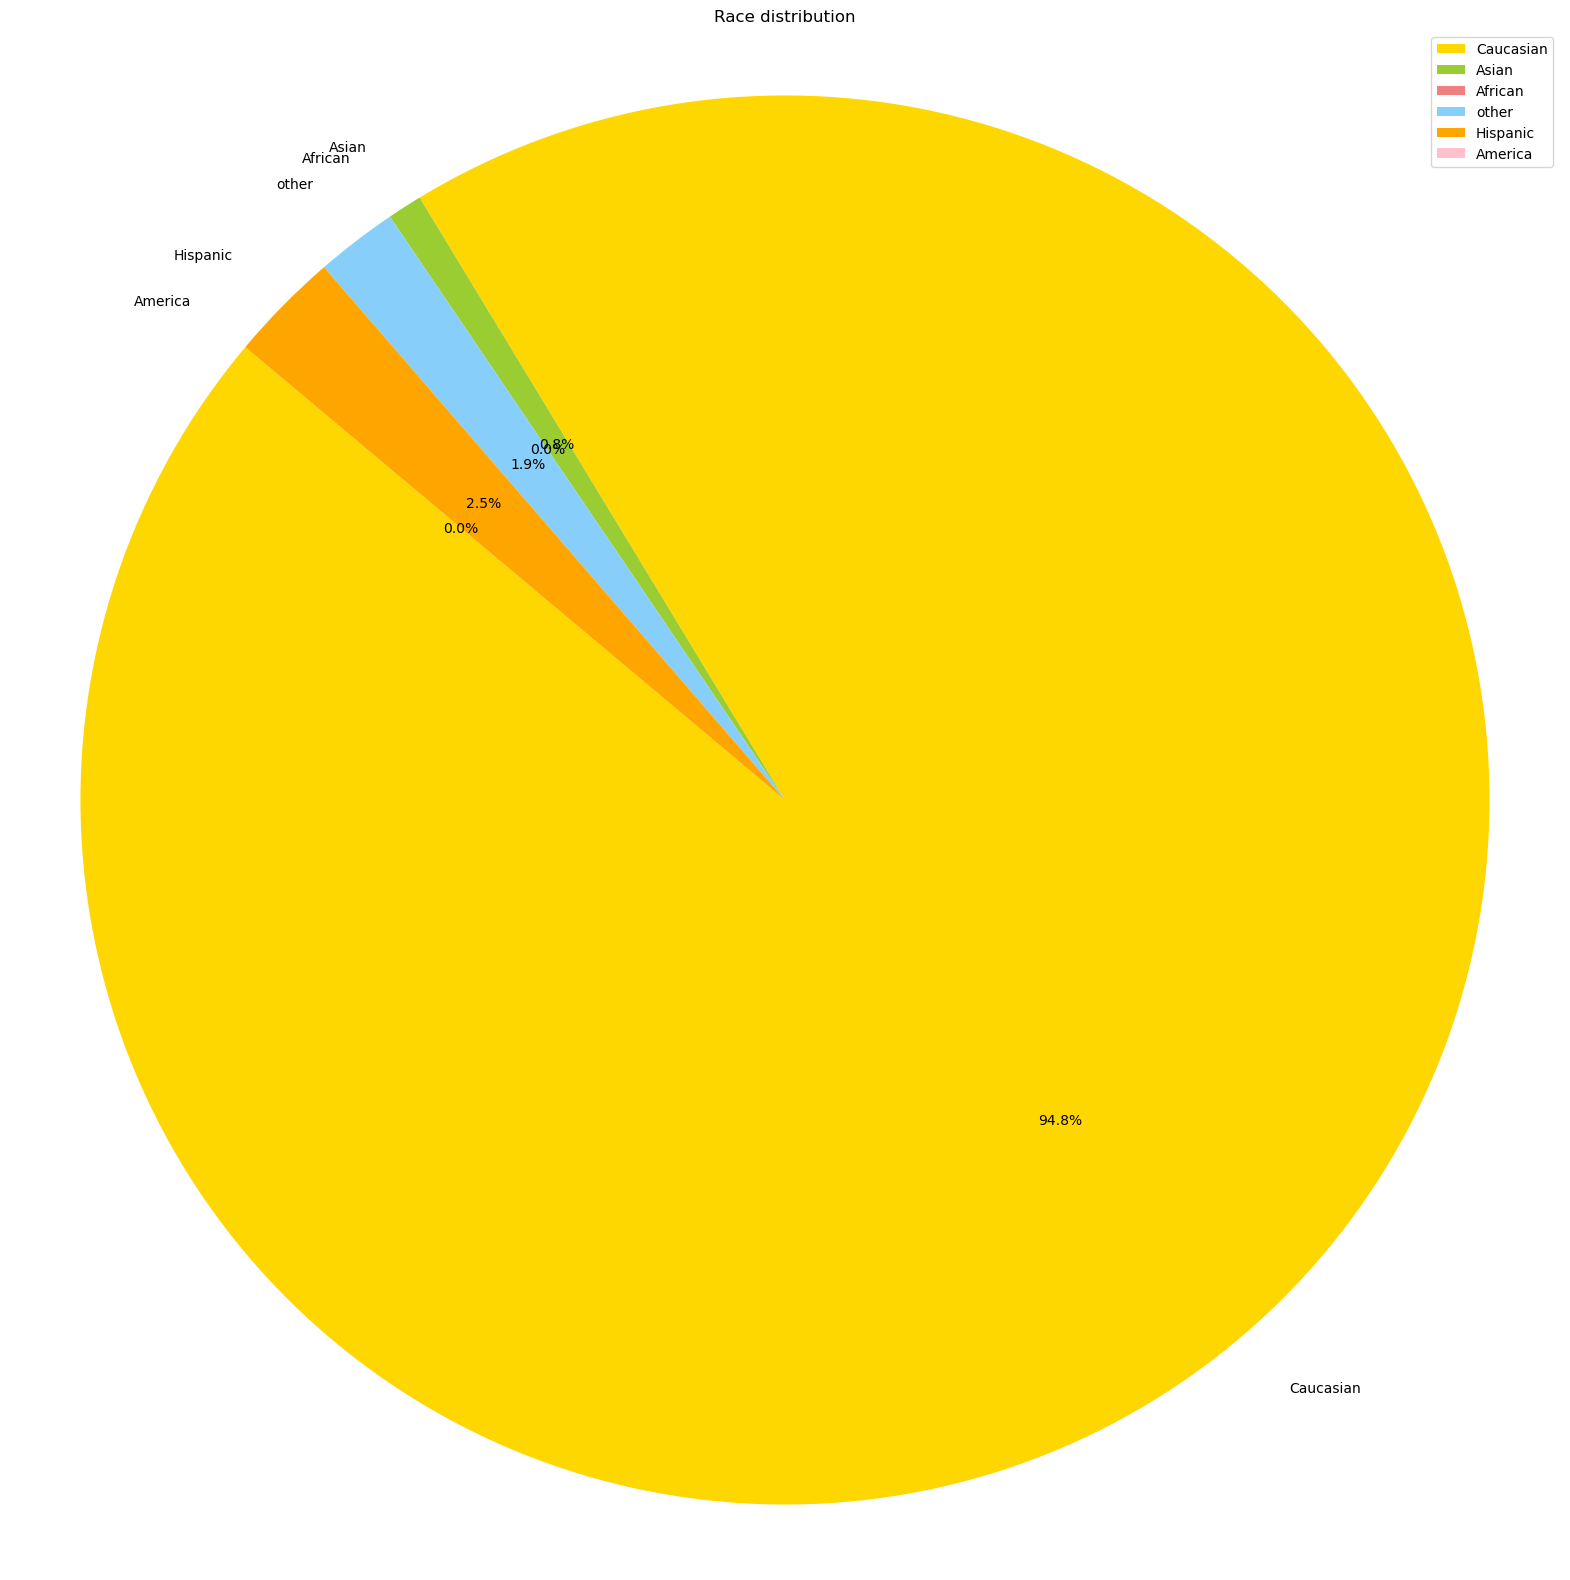

In [142]:
de.pie_race_distribution()

Percentage Normal: 0.00%
Percentage >8: 8.07%
Percentage >7: 3.75%
Percentage None: 0.00%


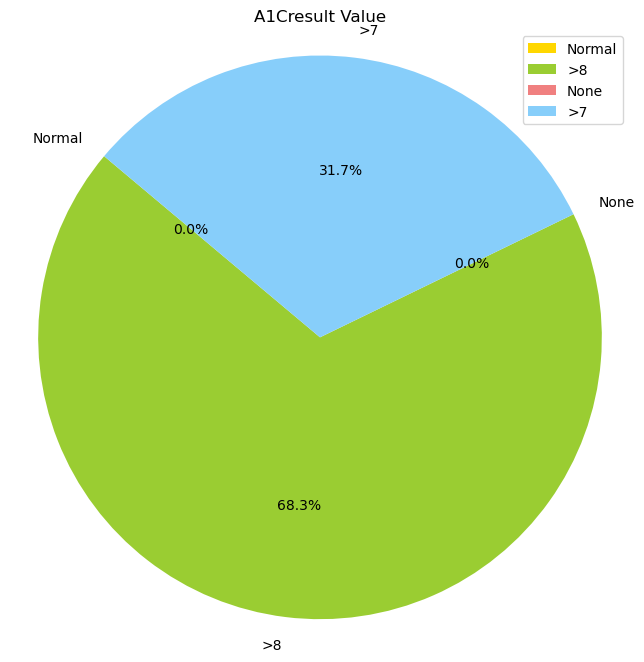

In [143]:
de.pie_a1cresult()

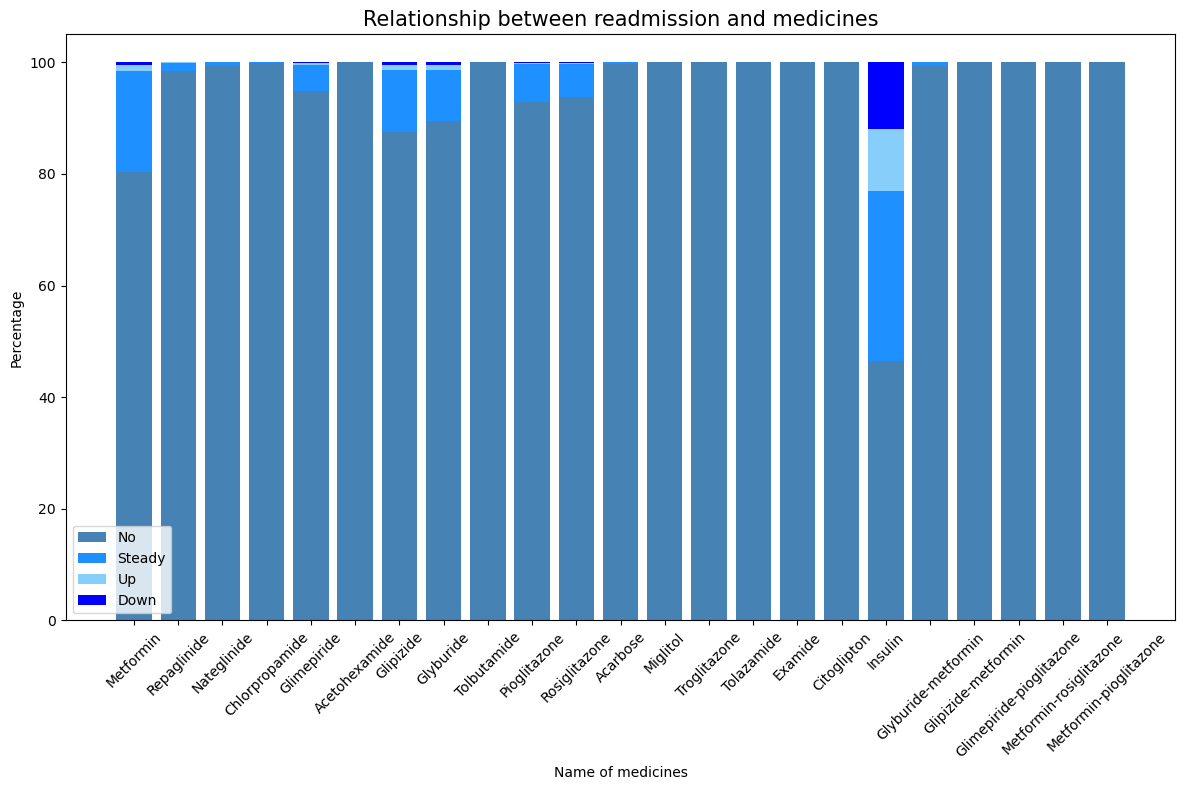

In [144]:
de.stacked_medicine_use_condition()

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


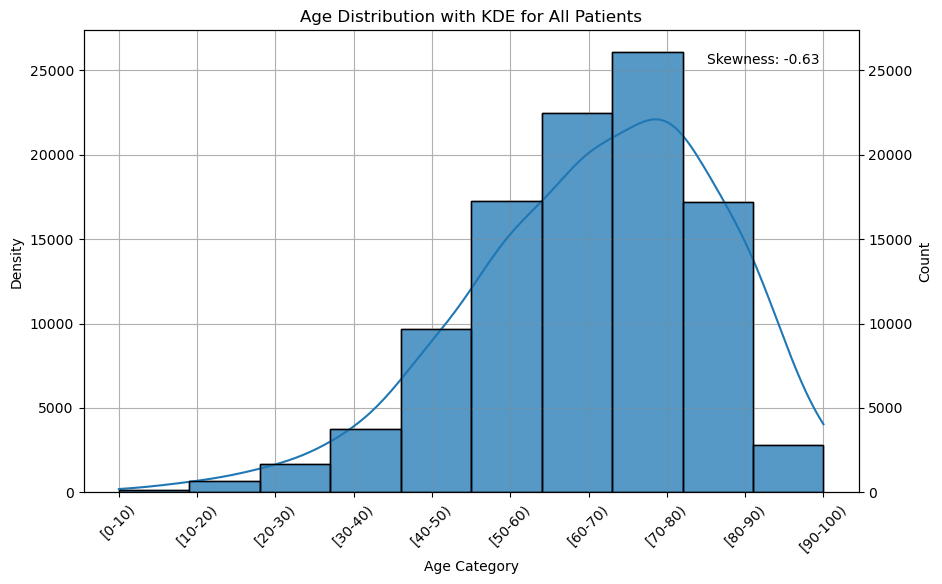

In [145]:
de.histogram_age_groups()

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


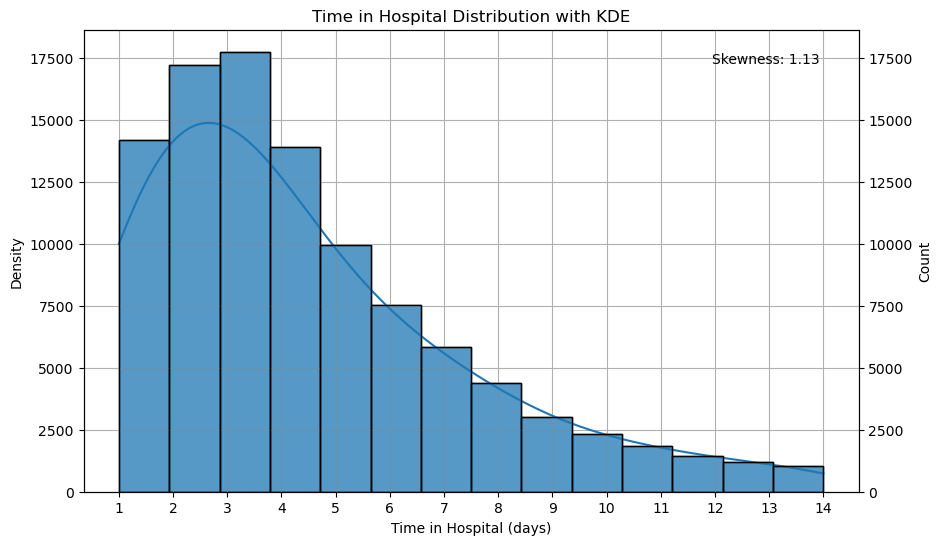

In [146]:
de.histogram_time_in_hospital()

101766
change 'No' and readmitted 'NO': 30.150541438201362%
change 'No' and readmitted '<30': 5.698366841577737%
change 'No' and readmitted '>30': 17.955898826720123%
change 'Ch' and readmitted 'NO': 23.7613741328145%
change 'Ch' and readmitted '<30': 5.461549043884991%
change 'Ch' and readmitted '>30': 16.97226971680129%


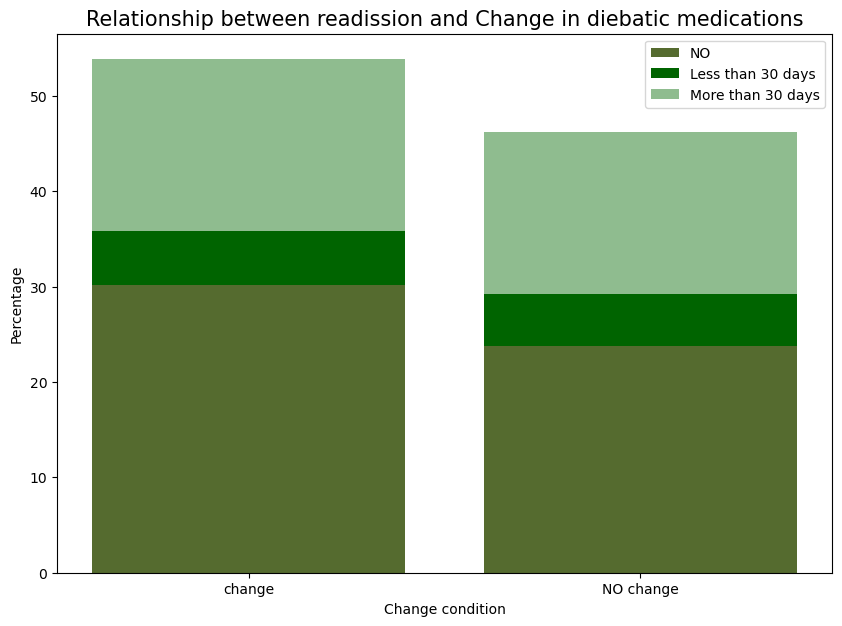

In [147]:
de.chart_change_in_medications()

101766
diabetesMed 'No' and readmitted 'NO': 13.688265235933416%
diabetesMed 'No' and readmitted '<30': 2.207023956920779%
diabetesMed 'No' and readmitted '>30': 7.101585991392017%
diabetesMed 'Yes' and readmitted 'NO': 40.223650335082446%
diabetesMed 'Yes' and readmitted '<30': 8.952891928541948%
diabetesMed 'Yes' and readmitted '>30': 27.8265825521294%


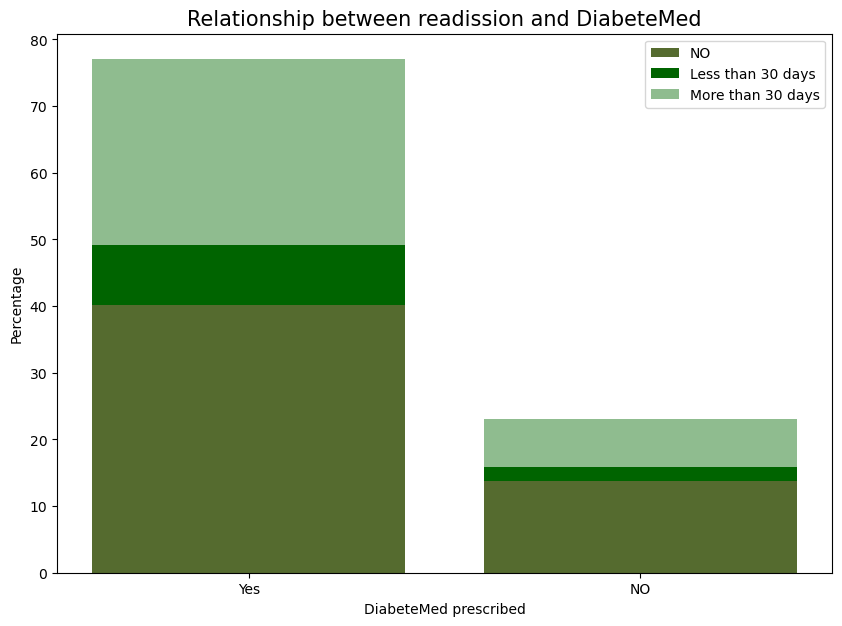

In [148]:
de.chart_diabetesMed()

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


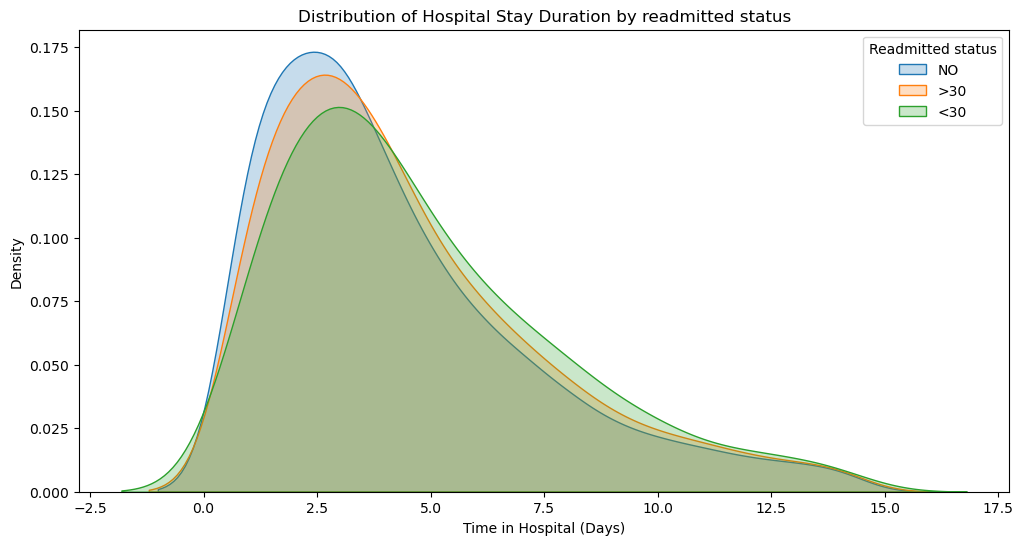

In [149]:
de.distribution_time_in_hospital()

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


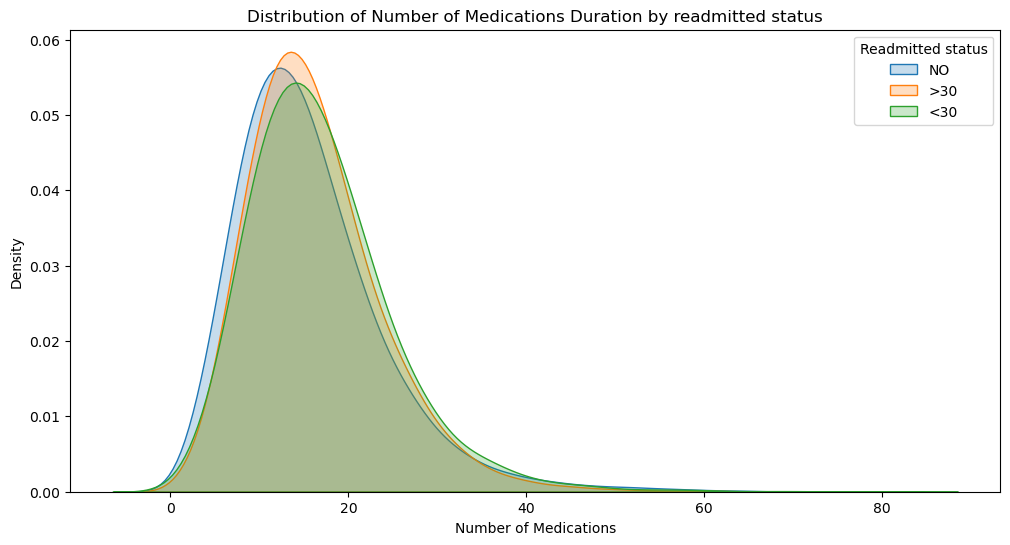

In [150]:
de.distribution_number_medications()

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


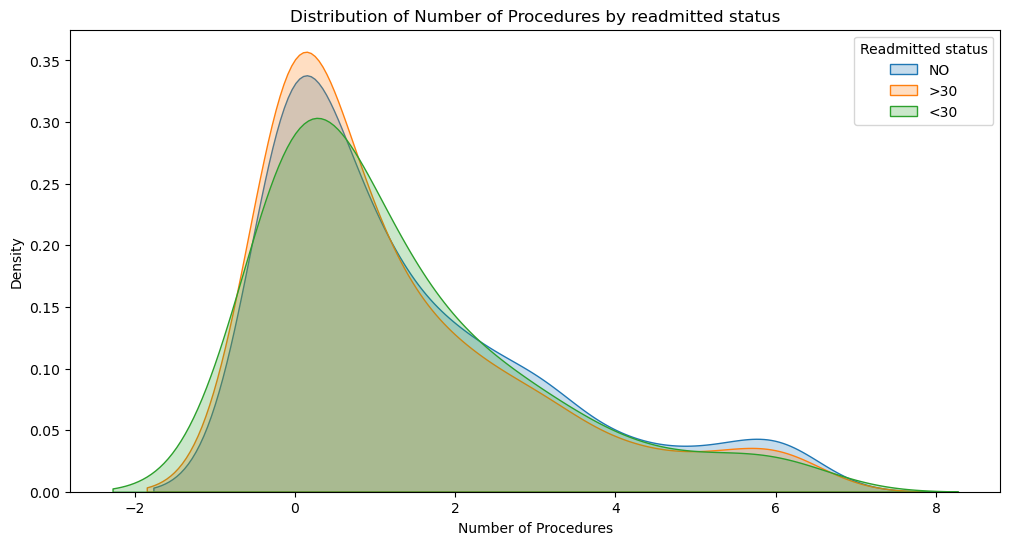

In [151]:
de.distribution_number_procedures()

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


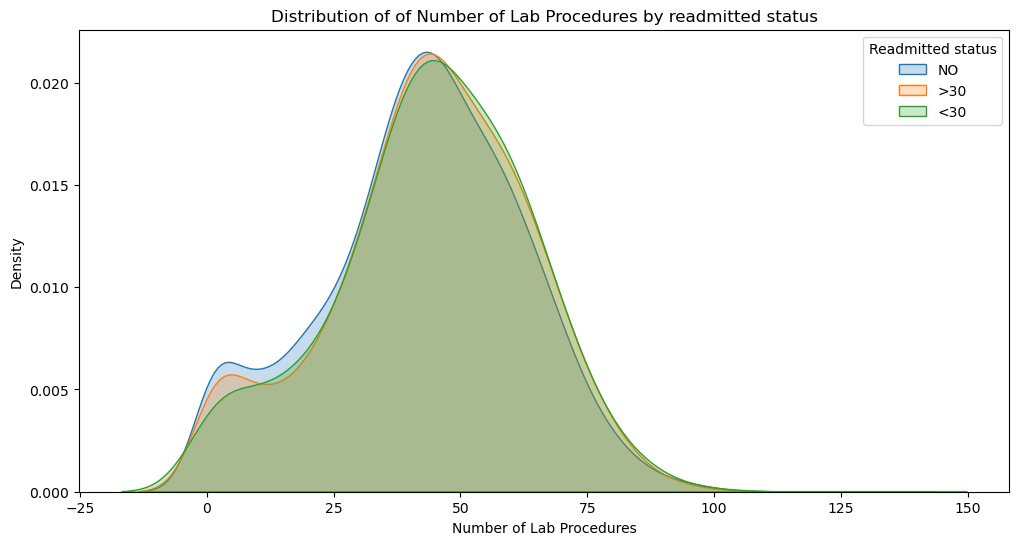

In [152]:
de.distribution_number_lab_procedures()

# Data Processing

In [153]:
USELESS_DATA_BOUNDARY= 0.3
FEATURE_FILTER_BOUNDARY = 0.03

In [154]:
class DataSet(object):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.processed_data = self.data

        self.useless_value_process()
        self.missing_value_process()
        self.tag_transfer()
        self.imputer_process()
        self.normalize()
        self.feature_filter()

    def useless_value_process(self):
        col_del = ['examide', 'citoglipton', 'glimepiride-pioglitazone','encounter_id','patient_nbr']
        self.processed_data.drop(col_del, axis=1, inplace = True)
    
    def missing_value_process(self):
        row_num = len(self.data)
        col_num = len(self.data.columns)
        cols_to_drop = []
        # Check all the features
        for col in range(col_num):
            # qm is short for Question Mark, which indicates a missing value
            qm_num = 0
            for row in range(row_num):
                # Check if the value is missing
                if str(self.data.iat[row,col]) == "?":
                    qm_num += 1

            # Print(qm_num/row_num), the percentage of missing values
            if qm_num/row_num >= USELESS_DATA_BOUNDARY:
                # Print("true") if the percentage is greater than the set boundary, and add the column to columns to drop
                cols_to_drop.append(self.data.columns[col])
        # Drop column
        self.processed_data.drop(columns=cols_to_drop, axis=1, inplace = True)

    def imputer_process(self):
        # Replace the question marks with the most frequently appeared value for each feature
        imp = SimpleImputer(missing_values= -1, strategy='most_frequent')
        imp.fit(self.processed_data)

    def tag_transfer(self): 

        le = LabelEncoder()
        #self.processed_data.replace('?', -1, inplace=True)
        value_to_keep = "?"

        for column in self.processed_data.columns:
            if self.processed_data[column].dtype == 'object':
                values_to_encode = self.processed_data[column] != value_to_keep
                encoded_values = le.fit_transform(self.processed_data.loc[values_to_encode, column])
                self.processed_data[column] = le.fit_transform(self.processed_data[column])
                self.processed_data[column].fillna(self.processed_data[column], inplace=True)

        self.processed_data.to_csv("./data/taged_train_data.csv",index=False)
        self.processed_data.to_csv("./data/taged_test_data.csv",index=False)

    def get_integer_mapping(self, le):
    
        res = {}
    
        for cl in le.classes_:
    
            res.update({cl:le.transform([cl])[0]})
    
        return res

    def normalize(self):
        # Normalize data using StandardScaler
        scaler = StandardScaler()
        column_names = self.processed_data.columns

        # Fit and transform the data
        self.processed_data = scaler.fit_transform(self.processed_data)

        # Convert the normalized data back to a DataFrame
        self.processed_data = pd.DataFrame(self.processed_data, columns=column_names)

        # Print normalized data
        print(self.processed_data)

    def feature_filter(self):
        importances = self.processed_data.drop('readmitted', axis=1).apply(lambda x: x.corr(self.processed_data.readmitted))

        # 只保留相关性高于阈值的特征
        importances = importances[importances.abs() > FEATURE_FILTER_BOUNDARY]

        # 获取排序后的索引
        indices = np.argsort(importances)

        plt.title('Readmitted')
        plt.barh(range(len(indices)), importances[indices], color='g', align='center')
        plt.yticks(range(len(indices)), [importances.index[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()


            race    gender       age  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient    diag_1    diag_2    diag_3  number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  tolbutamide  pioglitazone  rosiglitazone  acarbose  miglitol  troglitazone  tolazamide   insulin  glyburide-metformin  glipizide-metformin  metformin-rosiglitazone  metformin-pioglitazone    change  diabetesMed  readmitted
0       0.427557 -0.927397 -3.824600           2.750800                  4.031022            -1.169873         -1.137649           -0.106517       -0.785398        -1.848268          -0.291461          -0.21262         -0.503276 -1.325025  2.412242  2.123815         -3.321596       0.211734   0.415160  -0.449191    -0.113771    -0.079636       -0.027675    -0.209121  

/var/folders/f7/9y25vsd52n13lfvkbwc3yvch0000gn/T/ipykernel_40602/2229659670.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(range(len(indices)), importances[indices], color='g', align='center')


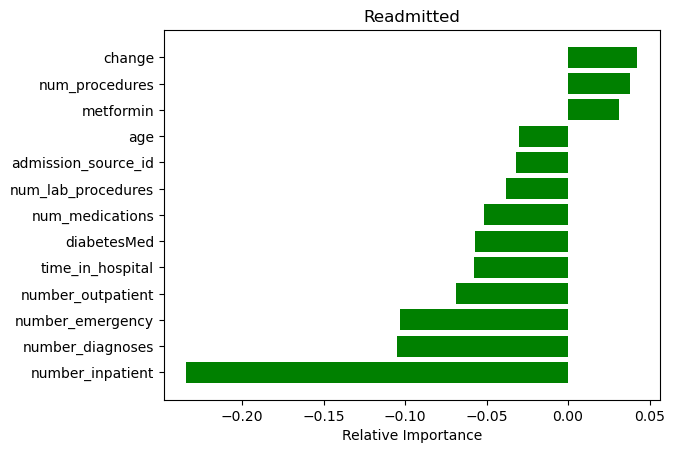

           race    gender       age  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient    diag_1    diag_2    diag_3  number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  tolbutamide  pioglitazone  rosiglitazone   acarbose  miglitol  troglitazone  tolazamide   insulin  glyburide-metformin  glipizide-metformin  metformin-rosiglitazone  metformin-pioglitazone    change  diabetesMed  readmitted
0      0.437862 -0.923795 -3.830404           2.724943                  4.064813            -1.156490         -1.148831           -0.114179       -0.790775        -1.842772          -0.305997         -0.243481         -0.513315 -1.320036  2.134067  2.012517         -3.318834       0.213462   0.416055  -0.435540    -0.110892    -0.081877       -0.029751    -0.204494   

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/f7/9y25vsd52n13lfvkbwc3yvch0000gn/T/ipykernel_40602/2229659670.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(range(len(indices)), importances[indices], color='g', align='center')


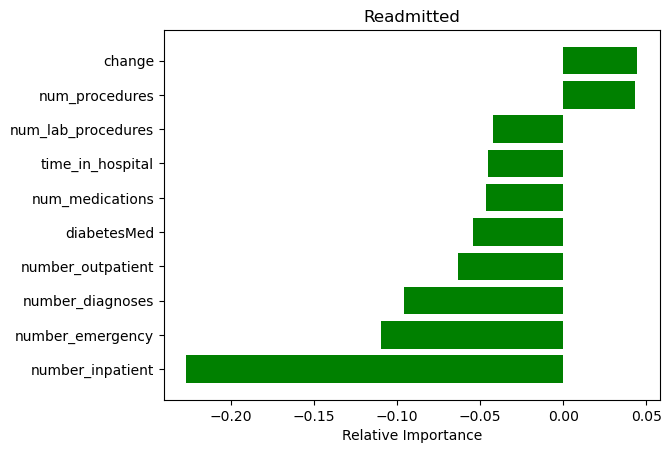

In [155]:
train_data = DataSet('./data/diabetic_data.csv')
test_data = DataSet('./data/diabetic_data_test.csv')

train_data.processed_data.to_csv("./data/processed_train_data.csv",index=False)
train_data.processed_data.to_csv("./data/processed_test_data.csv",index=False)

In [156]:
# Heat map

file_path = "./data/processed_train_data.csv"

# Load CSV data into a Pandas DataFrame
data = pd.read_csv(file_path)

# Find the covariance matrix of the dataset
cov_matrix = np.cov(data, rowvar=False)

# Print the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
[[ 1.00000983  0.05527198  0.11468466 ... -0.00932487 -0.00636667
  -0.01518423]
 [ 0.05527198  1.00000983 -0.05053594 ... -0.01490505  0.01590142
   0.01453304]
 [ 0.11468466 -0.05053594  1.00000983 ...  0.03601923 -0.0226014
  -0.03027152]
 ...
 [-0.00932487 -0.01490505  0.03601923 ...  1.00000983 -0.50637512
   0.04250394]
 [-0.00636667  0.01590142 -0.0226014  ... -0.50637512  1.00000983
  -0.05730618]
 [-0.01518423  0.01453304 -0.03027152 ...  0.04250394 -0.05730618
   1.00000983]]


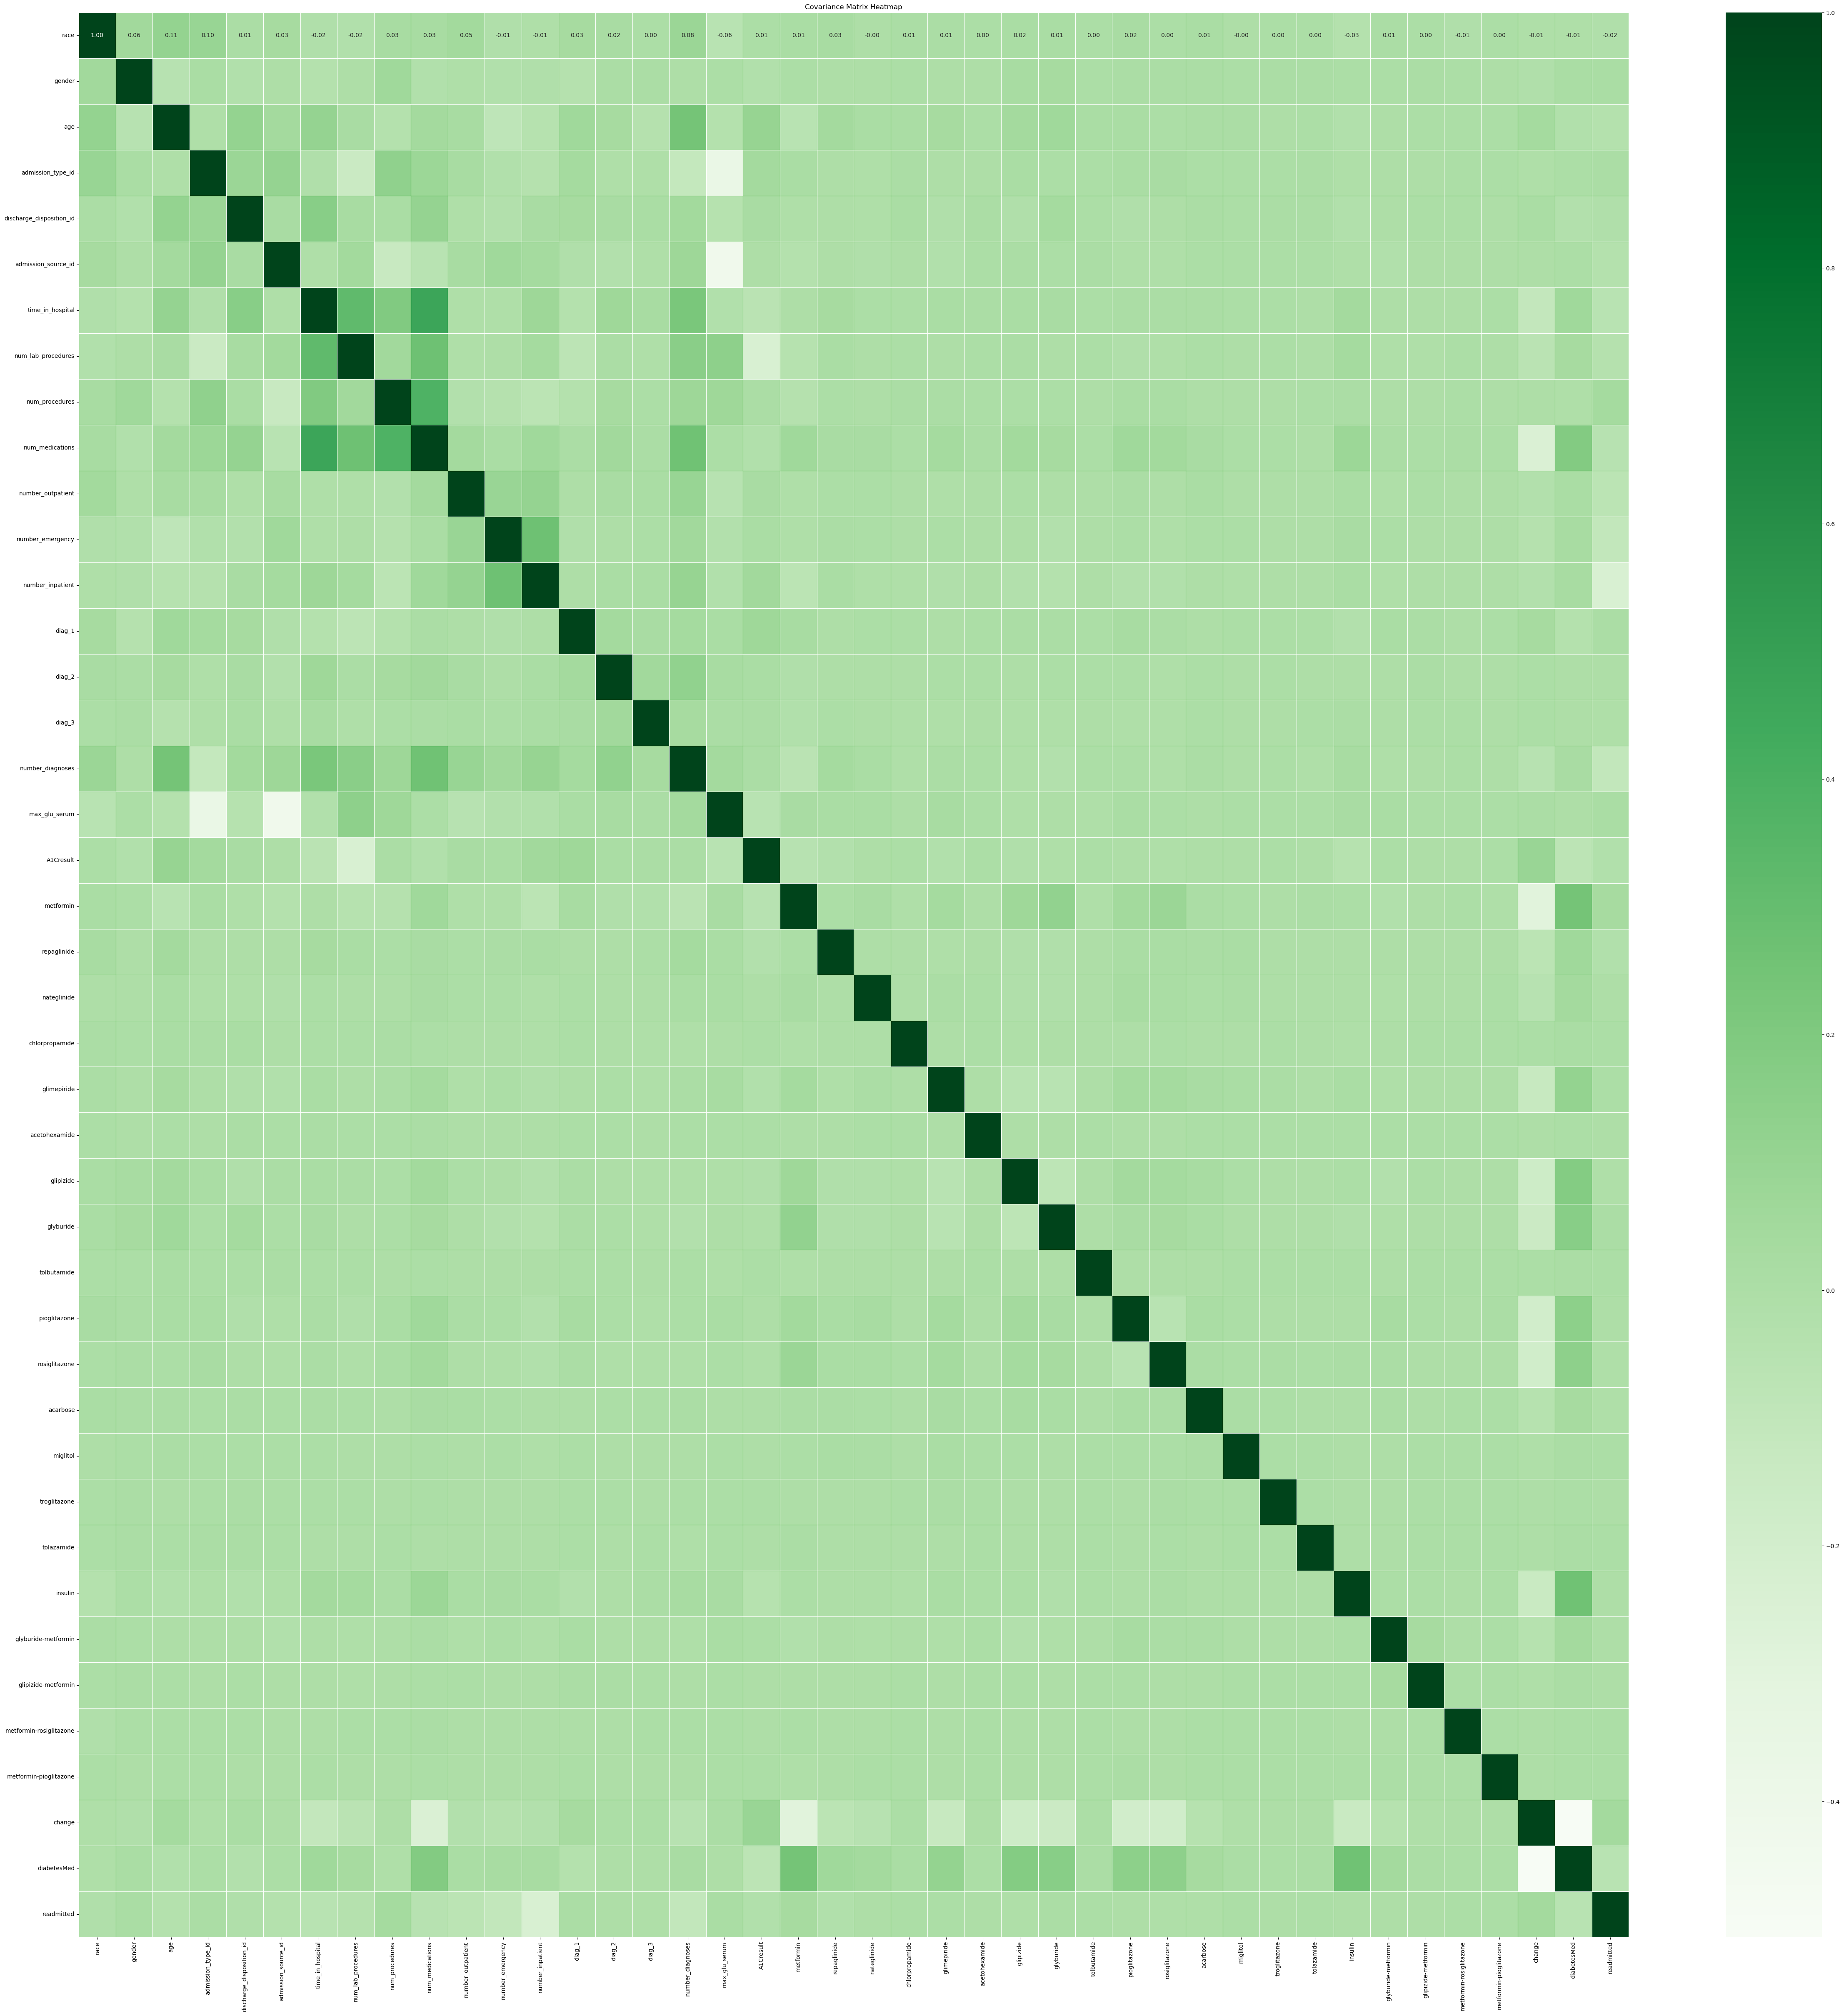

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the covariance matrix
cov_df = pd.DataFrame(cov_matrix, columns=data.columns, index=data.columns)

# Create a heatmap using seaborn
plt.figure(figsize=(60, 60))
sns.heatmap(cov_df, annot=True, cmap='Greens', fmt='.2f', linewidths=.5)
plt.title('Covariance Matrix Heatmap')
plt.show()

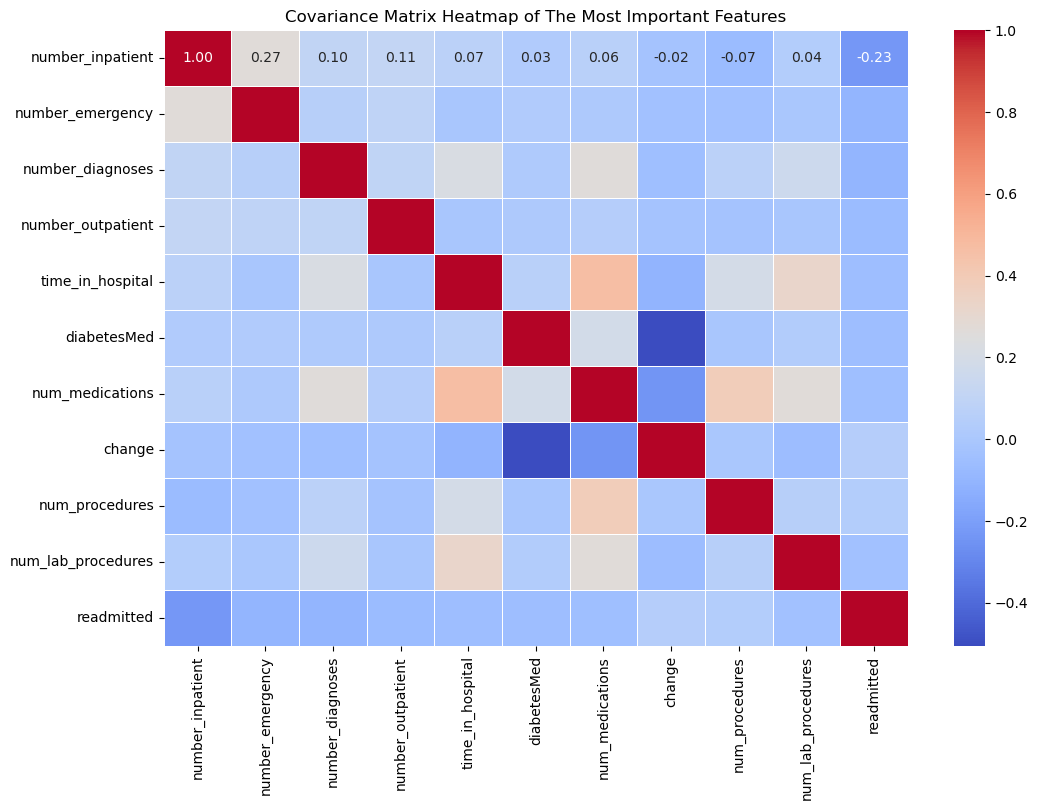

In [158]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset 
file_path = "./data/processed_train_data.csv"
data = pd.read_csv(file_path)

# Select the relevant features and the target variable
selected_features = [
    'number_inpatient', 'number_emergency', 'number_diagnoses',
    'number_outpatient', 'time_in_hospital', 'diabetesMed',
    'num_medications', 'change', 'num_procedures', 'num_lab_procedures', 'readmitted'
]

# Create a subset of the data with the selected features
subset_data = data[selected_features]

# Compute the covariance matrix
cov_matrix = subset_data.cov()

# Plot the covariance matrix heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Covariance Matrix Heatmap of The Most Important Features')
plt.show()

Covariance Matrix:
[[ 1.00000983  0.05527198  0.11468466 ... -0.00932487 -0.00636667
  -0.01518423]
 [ 0.05527198  1.00000983 -0.05053594 ... -0.01490505  0.01590142
   0.01453304]
 [ 0.11468466 -0.05053594  1.00000983 ...  0.03601923 -0.0226014
  -0.03027152]
 ...
 [-0.00932487 -0.01490505  0.03601923 ...  1.00000983 -0.50637512
   0.04250394]
 [-0.00636667  0.01590142 -0.0226014  ... -0.50637512  1.00000983
  -0.05730618]
 [-0.01518423  0.01453304 -0.03027152 ...  0.04250394 -0.05730618
   1.00000983]]


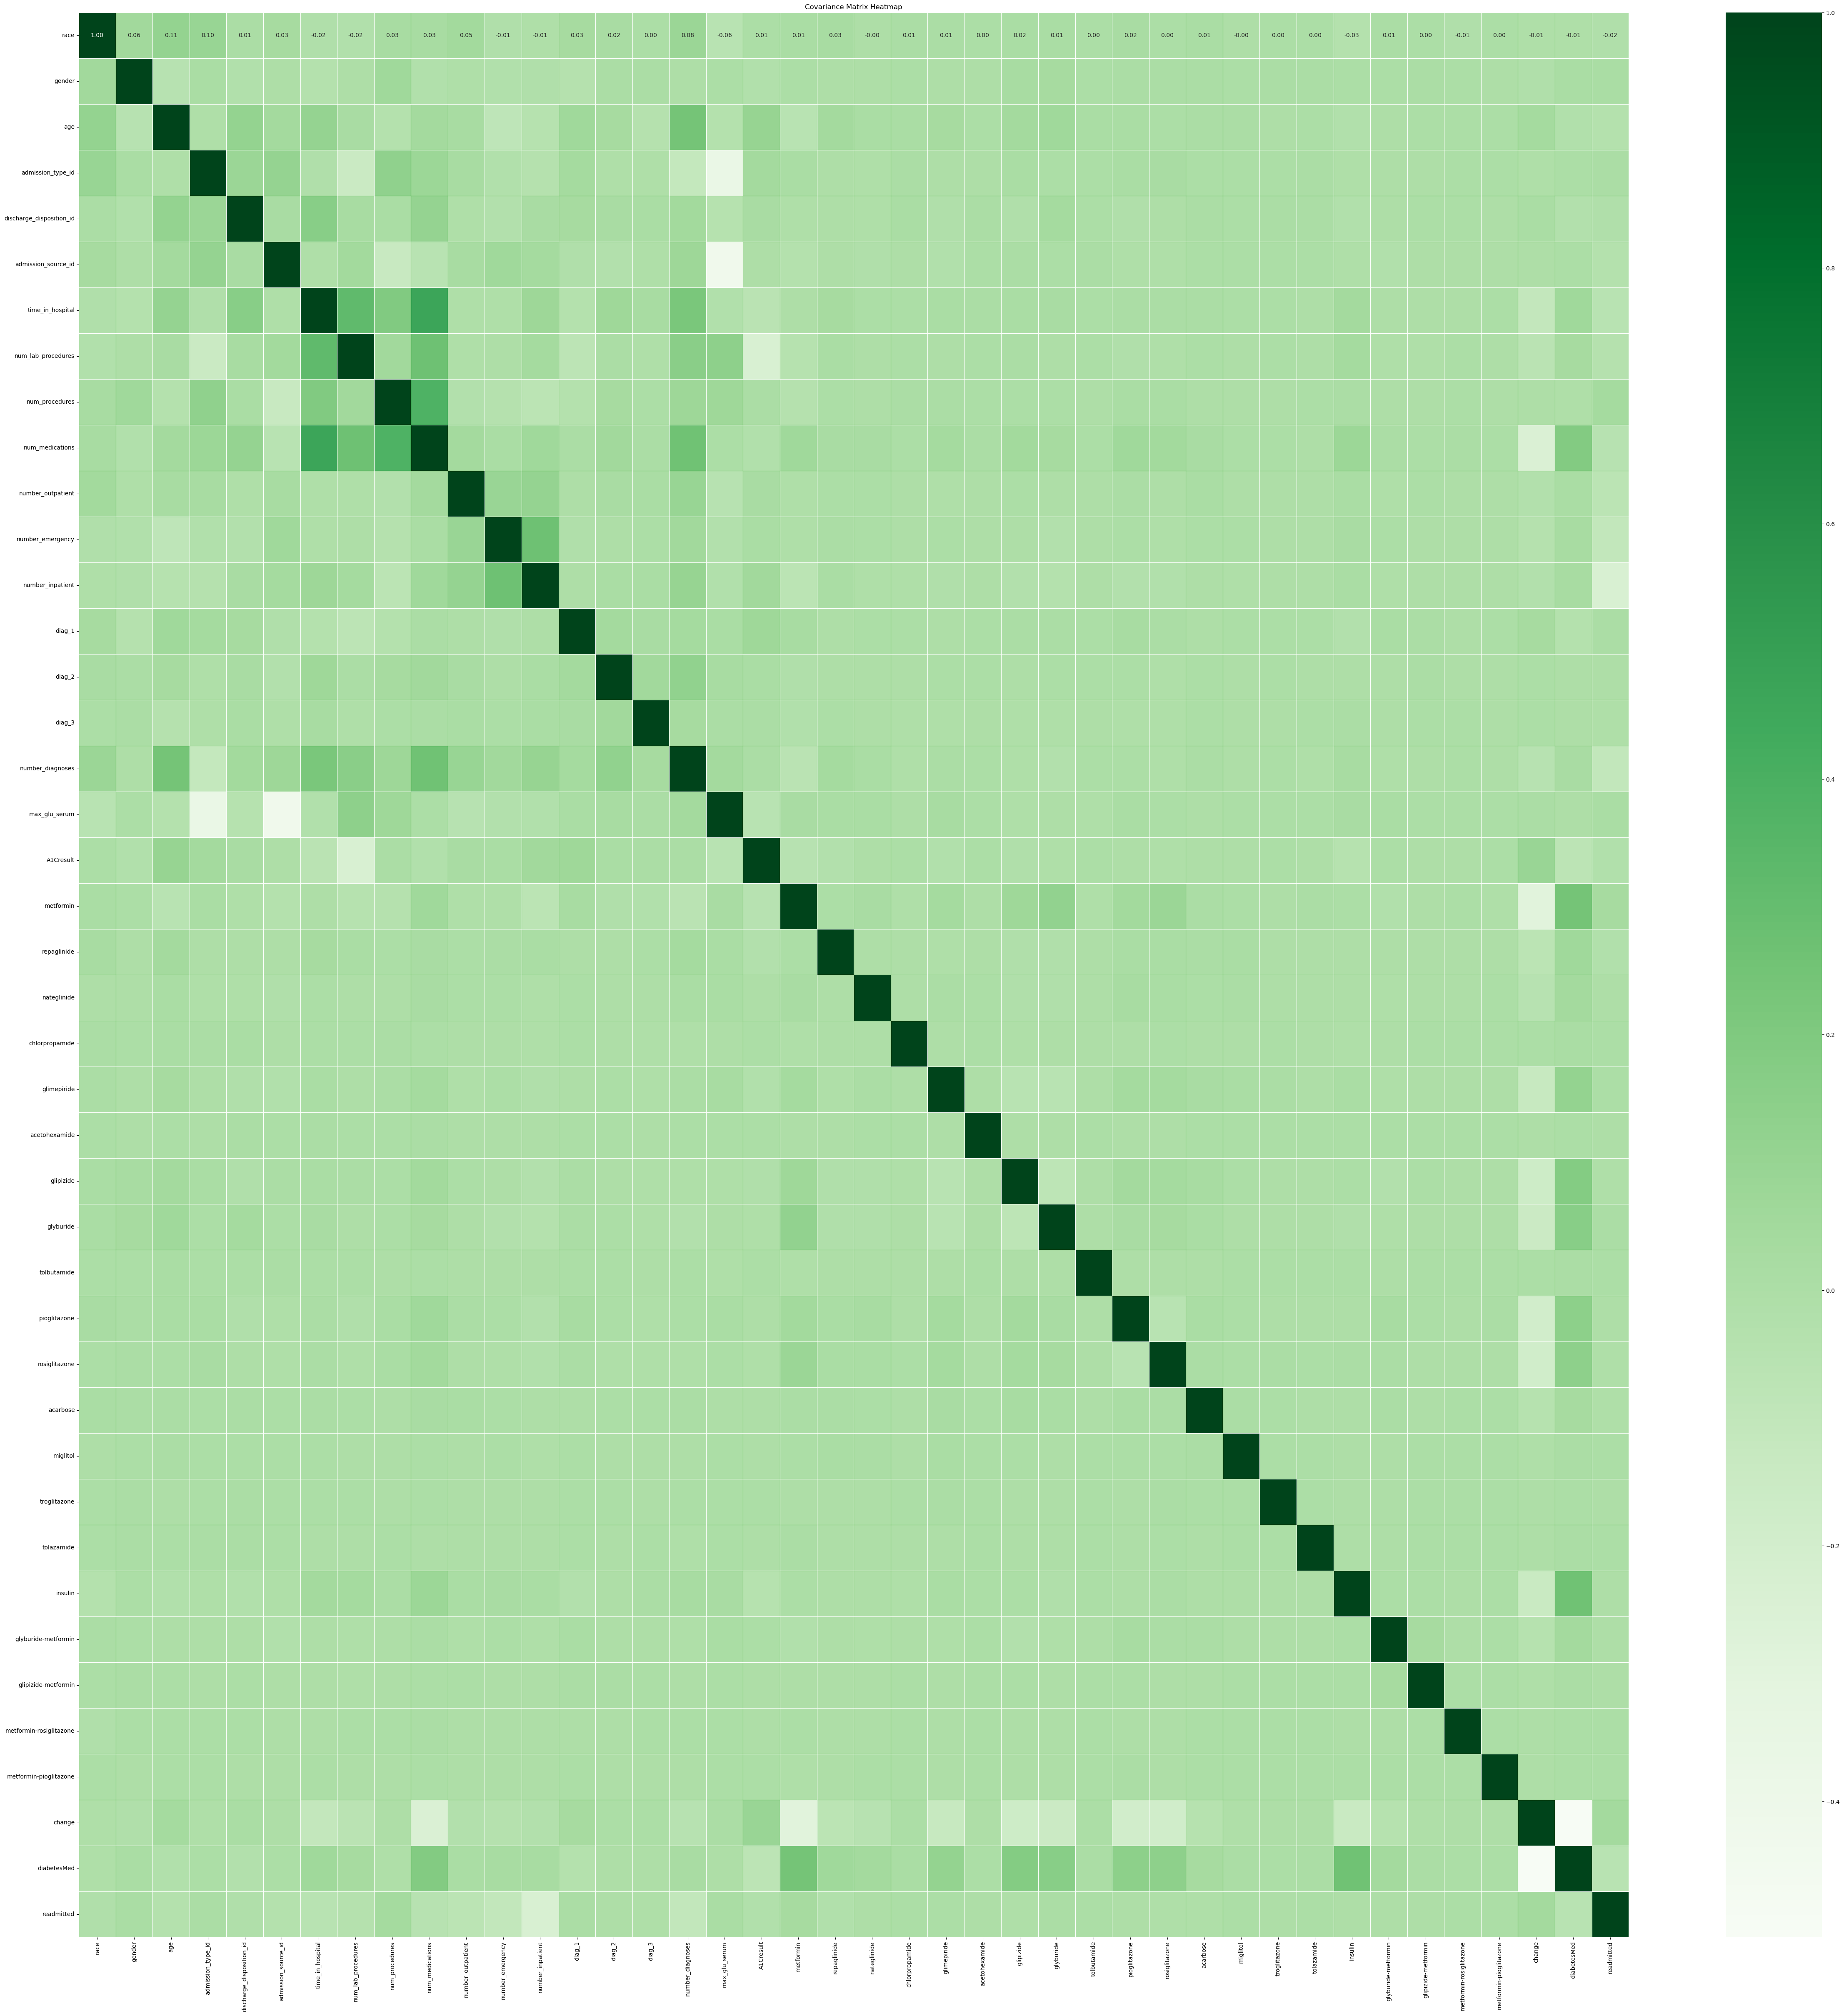

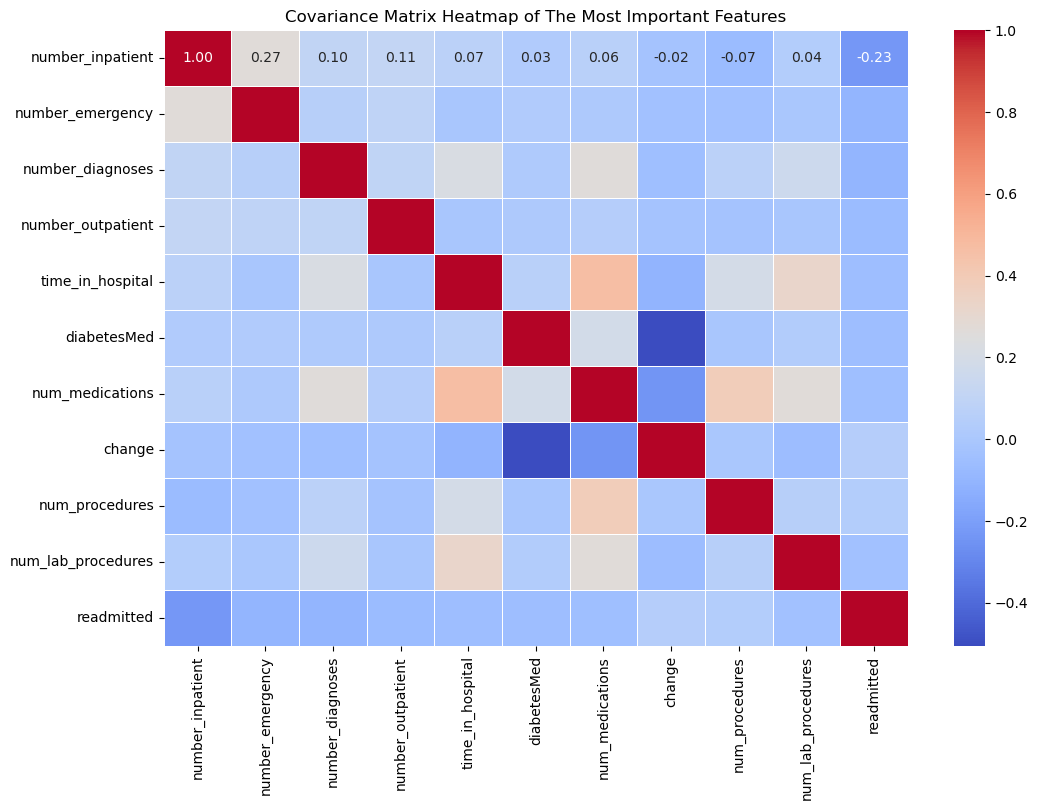

In [159]:
# Data Transformation Part

# Plot the Heatmap of the data

file_path = "./data/processed_train_data.csv"

# Load CSV data into a Pandas DataFrame
data = pd.read_csv(file_path)

# Find the covariance matrix of the dataset
cov_matrix = np.cov(data, rowvar=False)

# Print the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

# Create a DataFrame from the covariance matrix
cov_df = pd.DataFrame(cov_matrix, columns=data.columns, index=data.columns)

# Create a heatmap using seaborn
plt.figure(figsize=(60, 60))
sns.heatmap(cov_df, annot=True, cmap='Greens', fmt='.2f', linewidths=.5)
plt.title('Covariance Matrix Heatmap')
plt.show()

# Select the relevant features and the target variable
selected_features = [
    'number_inpatient', 'number_emergency', 'number_diagnoses',
    'number_outpatient', 'time_in_hospital', 'diabetesMed',
    'num_medications', 'change', 'num_procedures', 'num_lab_procedures', 'readmitted'
]

# Create a subset of the data with the selected features
subset_data = data[selected_features]

# Compute the covariance matrix
cov_matrix = subset_data.cov()

# Plot the covariance matrix heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Covariance Matrix Heatmap of The Most Important Features')
plt.show()


# Modeling

In [181]:
train_data = pd.read_csv('./data/processed_train_data.csv')
test_data = pd.read_csv('./data/processed_test_data.csv')

predictor = train_data.iloc[:,:-1].values
response = train_data.iloc[:,-1].values

predictor,response 

(array([[ 4.27557387e-01, -9.27396749e-01, -3.82459963e+00, ...,
         -3.13473463e-03,  9.26590521e-01, -1.82986799e+00],
        [ 4.27557387e-01, -9.27396749e-01, -3.19727694e+00, ...,
         -3.13473463e-03, -1.07922537e+00,  5.46487508e-01],
        [-1.70370587e+00, -9.27396749e-01, -2.56995426e+00, ...,
         -3.13473463e-03,  9.26590521e-01,  5.46487508e-01],
        ...,
        [ 4.27557387e-01,  1.07803147e+00,  5.66659179e-01, ...,
         -3.13473463e-03, -1.07922537e+00,  5.46487508e-01],
        [ 4.27557387e-01, -9.27396749e-01,  1.19398187e+00, ...,
         -3.13473463e-03, -1.07922537e+00,  5.46487508e-01],
        [ 4.27557387e-01,  1.07803147e+00,  5.66659179e-01, ...,
         -3.13473463e-03,  9.26590521e-01, -1.82986799e+00]]),
 array([ 0.8368795 , -0.62496982,  0.8368795 , ...,  0.8368795 ,
         0.8368795 ,  0.8368795 ]))

In [182]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from imblearn.over_sampling import SMOTE


In [183]:
def model_maker(train_data, test_data, model_type):
    # Separate features and target variable
    X_train = train_data.drop('readmitted', axis=1)  # Extract features for training
    y_train = train_data['readmitted']               # Extract target variable for training
    X_test = test_data.drop('readmitted', axis=1)    # Extract features for testing
    y_test = test_data['readmitted']                 # Extract target variable for testing

    # Create a logistic regression model
    if model_type == "lgr":
        model = LogisticRegression(max_iter=1000) # Initialize the Logistic Regression model
    elif model_type == "knn":
        model = KNeighborsClassifier(n_neighbors=3)
    elif model_type == "rf":
        model = RandomForestClassifier(n_estimators=100, max_depth=5)
    elif model_type == "dt":
        model = DecisionTreeClassifier(max_depth=5, min_samples_split=4, min_samples_leaf=2)

    # Train the model
    model.fit(X_train, y_train)   # Fit the model to the training data

    # Evaluate the model
    model_pred = model.predict(X_test.values)

    pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(model_pred, name = 'Predict'), margins = True)

    print("Accuracy is {0:.2f}".format(accuracy_score(y_test, model_pred)))
    print("Precision is {0:.2f}".format(precision_score(y_test, model_pred, average='weighted')))
    print("Recall is {0:.2f}".format(recall_score(y_test, model_pred, average='weighted')))

    # Predict with new data if needed
    # prediction = model.predict(new_data)

    return model, X_train, y_train, X_test, y_test



In [184]:
def graph_feature_importance(model, X_train):
    # 1. Learning
    feature_importance = model.feature_importances_
    features = X_train.columns
    indices = np.argsort(feature_importance)

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
def graph_learning_curve(model, X_train, y_train):
    # 2. Learning
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

def graph_confusion_matrix(model, X_test, y_test):
    # 3. Confusion matrix
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

def graph_roc_auc(model, X_test, y_test):
    # 4. ROC curve and AUC score
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]

    # Calculate ROC curve and AUC score for each category
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        y_pred_prob = model.predict_proba(X_test)[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC curve
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()

def graph_feature_weight(model, X_train):
    # 5. Feature weight
    feature_importance = model.coef_[0]
    features = X_train.columns
    indices = np.argsort(feature_importance)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

## K-Nearest Neighbors(KNN)

In [185]:
# Load training and testing data
train_data = pd.read_csv('./data/taged_train_data.csv')  # Load training data from a CSV file
test_data = pd.read_csv('./data/taged_test_data.csv')    # Load testing data from a CSV file

model_maker(train_data, test_data, 'knn')

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy is 0.70
Precision is 0.71
Recall is 0.70


(KNeighborsClassifier(n_neighbors=3),
        race  gender  age  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient  diag_1  diag_2  diag_3  number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  nateglinide  chlorpropamide  glimepiride  acetohexamide  glipizide  glyburide  tolbutamide  pioglitazone  rosiglitazone  acarbose  miglitol  troglitazone  tolazamide  insulin  glyburide-metformin  glipizide-metformin  metformin-rosiglitazone  metformin-pioglitazone  change  diabetesMed
 0         3       0    0                  6                        25                    1                 1                  41               0                1                  0                 0                 0      81     406     419                 1              3          3          1            1            1               1            1             

## Logistic Regression

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy is 0.57
Precision is 0.53
Recall is 0.57


/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

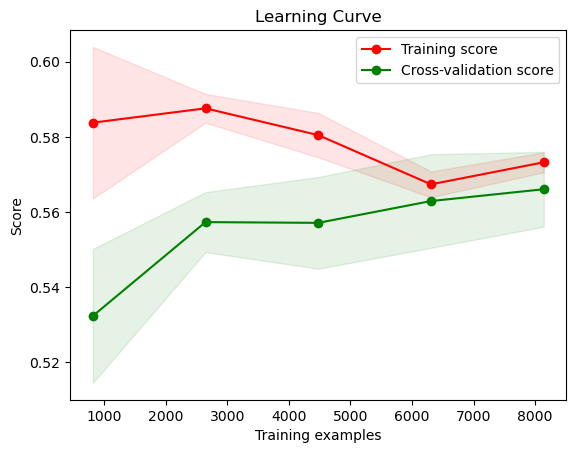

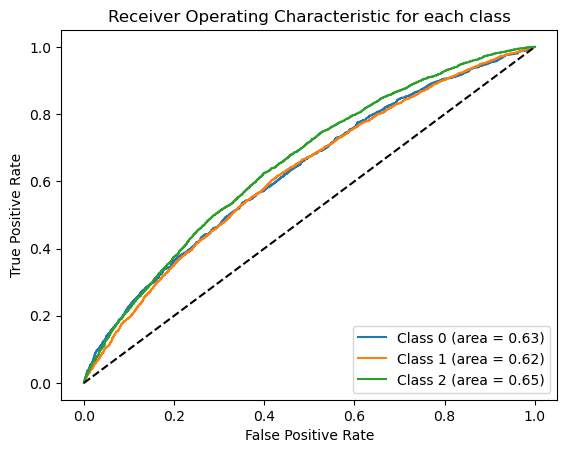

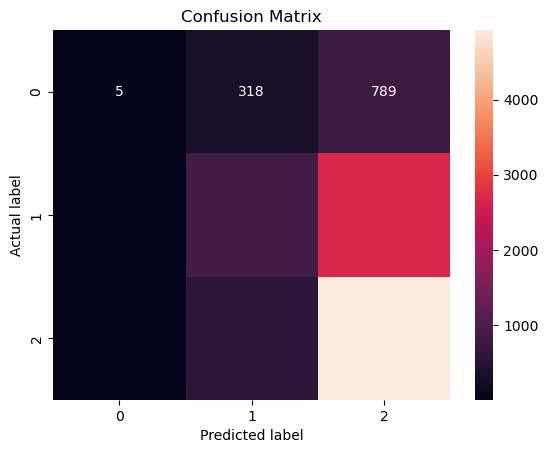

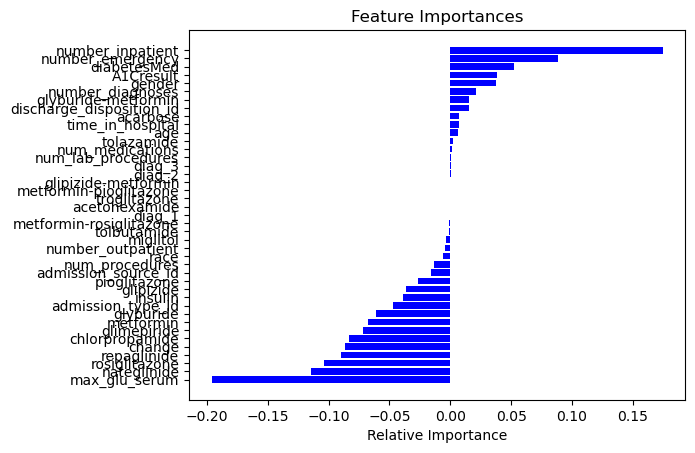

In [189]:
# Load training and testing data
train_data = pd.read_csv('./data/taged_train_data.csv')  # Load training data from a CSV file
test_data = pd.read_csv('./data/taged_test_data.csv')    # Load testing data from a CSV file

model, X_train, y_train, X_test, y_test = model_maker(train_data, test_data, 'lgr')

graph_learning_curve(model, X_train, y_train)
graph_roc_auc(model, X_test, y_test)
graph_confusion_matrix(model, X_test, y_test)
graph_feature_weight(model, X_train)


## Decision Tree

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Accuracy is 0.59
Precision is 0.58
Recall is 0.59


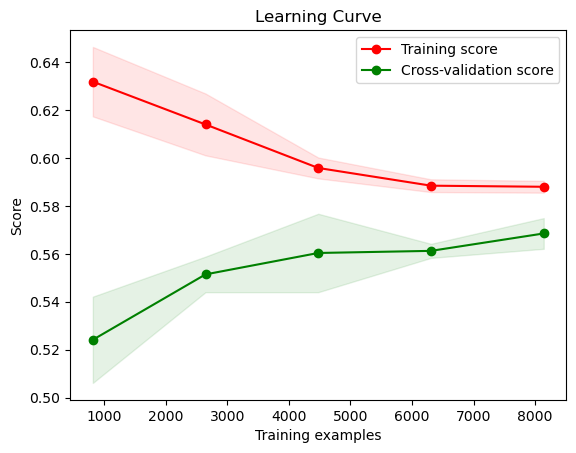

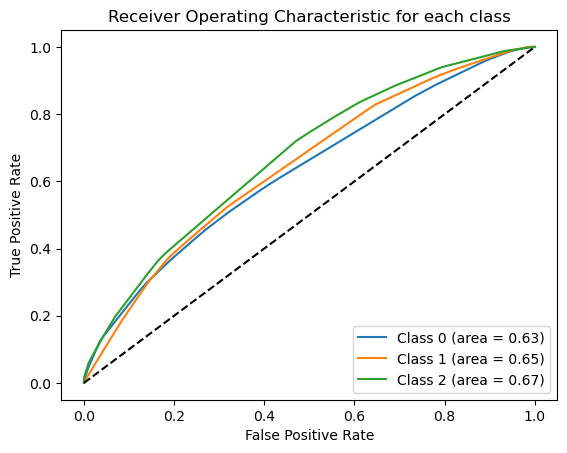

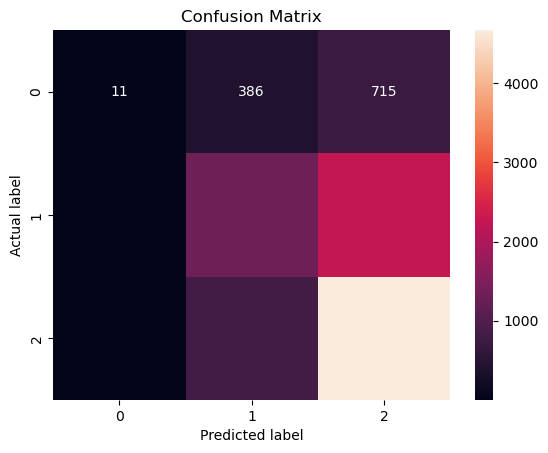

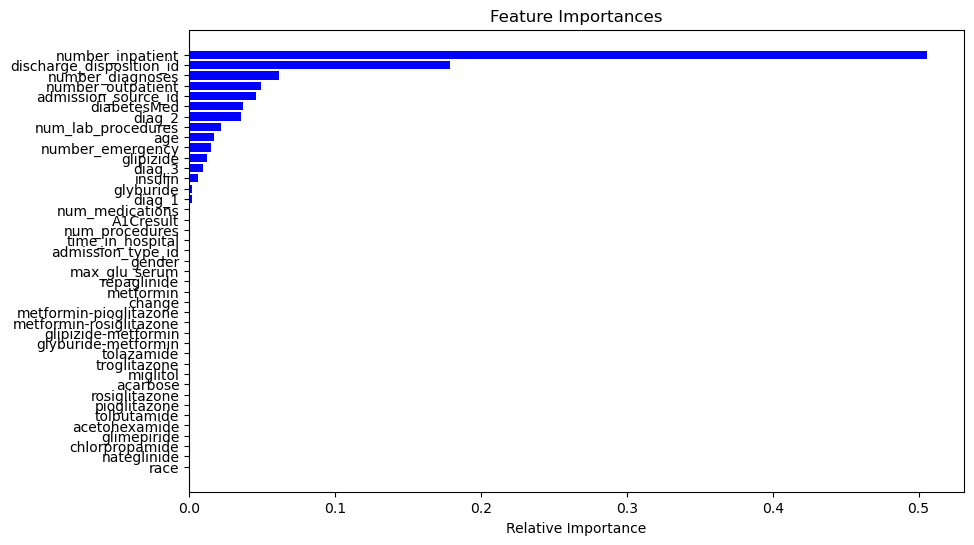

In [190]:
train_data = pd.read_csv('./data/taged_train_data.csv')  # Load training data from a CSV file
test_data = pd.read_csv('./data/taged_test_data.csv')    # Load testing data from a CSV file

model, X_train, y_train, X_test, y_test = model_maker(train_data, test_data, 'dt')
graph_learning_curve(model, X_train, y_train)
graph_roc_auc(model, X_test, y_test)
graph_confusion_matrix(model, X_test, y_test)
graph_feature_importance(model, X_train)


## Random Forest

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy is 0.58
Precision is 0.52
Recall is 0.58


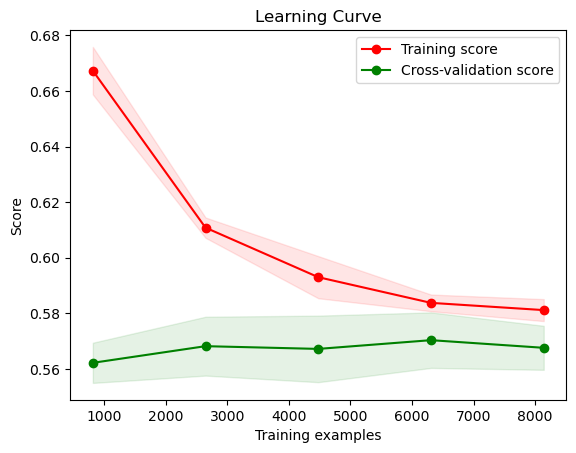

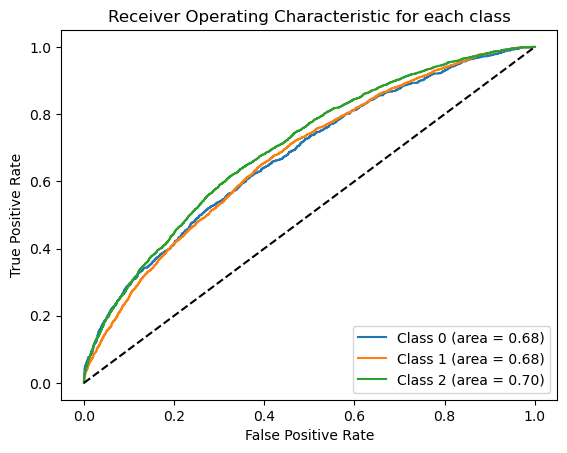

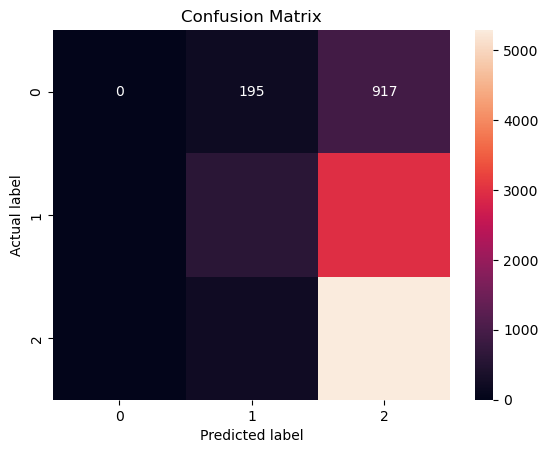

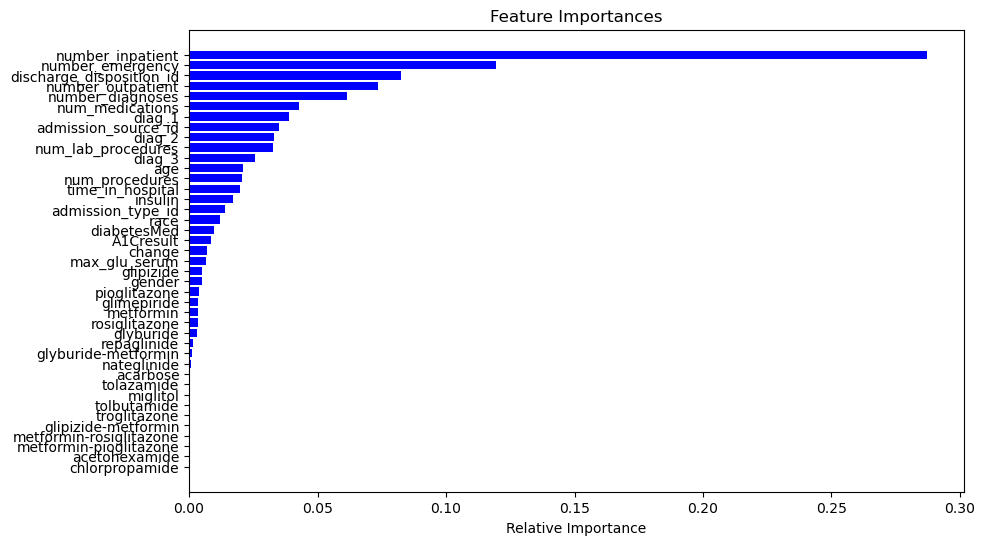

In [191]:
train_data = pd.read_csv('./data/taged_train_data.csv')  # Load training data from a CSV file
test_data = pd.read_csv('./data/taged_test_data.csv')    # Load testing data from a CSV file

model, X_train, y_train, X_test, y_test = model_maker(train_data, test_data, 'rf')

graph_learning_curve(model, X_train, y_train)
graph_roc_auc(model, X_test, y_test)
graph_confusion_matrix(model, X_test, y_test)
graph_feature_importance(model, X_train)